# TC2 Tech Challenge for CapTech

In [71]:
from __future__ import division
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import operator
import collections
from collections import Counter
from time import gmtime, strftime, strptime, mktime
from datetime import date

%pylab inline
matplotlib.rcParams['figure.figsize'] = (12,6)

Populating the interactive namespace from numpy and matplotlib


### Functions for Notebook

In [72]:
#function to receive counter objects, sorting by keys or values, and the way we wish graph to be sorted
def sort_for_graph(uodict,sort_key,order):
    if sort_key == "key":
        key_num=0
    elif sort_key == "value":
        key_num=1
        
    if order == "desc":
        orderBool = True
    elif order == "asc":
        orderBool = False
    odict = sorted(uodict.items(), key=operator.itemgetter(key_num),reverse=orderBool)
    keys = zip(*odict)[0]
    values = zip(*odict)[1]
    
    return keys,values

In [73]:
#Function to Create Quartiles for Analysis
def create_quartiles(minimum,first,second,third,maximum,df):
    bins = (minimum,first,second,third,maximum)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df, bins, labels=group_names)
    return categories

In [74]:
#function to create categories for net_amount
def get_net_amount(sub_df,category,funded_amnt,total_pymnt):
    sub_df = sub_df.loc[:,[category, funded_amnt,total_pymnt]]
    sub_df.funded_amnt = sub_df[funded_amnt].astype('float')
    sub_df['net_amnt'] = sub_df[total_pymnt] - sub_df[funded_amnt]
    del sub_df[funded_amnt]
    del sub_df[total_pymnt]
    return sub_df.groupby([category]).sum()

In [75]:
#function to convert dates from yymmddTHHMMSS format that loans file is in
def convert_date(x):
    if type(x) is str:
        return strftime("%m-%d-%Y", strptime(x, "%Y%m%dT%H%M%S"))
    else:
        return "00-00-0000"

### Load Loan Population File

In [76]:
#creating Pandas dataframe from CSV file
loans_df = pd.read_csv('loanStats.csv')

### Clean Up NaNs

In [77]:
loans_df['inq_last_6mths'].fillna(0,inplace=True)
loans_df['delinq_2yrs'].fillna(0,inplace=True)

### Create 10% Sample of Loan Population

In [78]:
#sample has already been populated using below code, now begin reloading using pickle file

#create sample with 10% of loans_df population file
#loan_sample_df = loans_df.sample(frac=.1)
#loan_sample_df.to_pickle('loans_sample_df.pkl')

loan_sample_df = pd.read_pickle('loans_sample_df.pkl')

### Clean Up Date Columns

In [79]:
#slice dataset into just columns with date
loan_dates_df = loans_df.loc[:,['issue_d','earliest_cr_line','next_pymnt_d','last_credit_pull_d','final_d','last_pymnt_d']]
#rename the columns to add at the end of DataFrame
for i in range(len(loan_dates_df.keys())):
    loan_dates_df.rename(columns={loan_dates_df.keys()[i]: loan_dates_df.keys()[i]+'_fmt'}, inplace=True)
#reformat dates using function
loan_dates_df = loan_dates_df.applymap(convert_date)
loans_df = pd.merge(loans_df, loan_dates_df, left_index=True, right_index=True) #merge into existing table

#### 1) Comparing Sample to Population

In [80]:
df1 = pd.DataFrame({'Population': loans_df['loan_amnt']})
df2 = pd.DataFrame({'Sample': loan_sample_df['loan_amnt']})
pop_to_sample_df = pd.concat([df1, df2], axis=1)

In [81]:
pop_to_sample_stats = pd.DataFrame({'Population':pd.Series([pop_to_sample_df['Population'].mean(), \
                                                     pop_to_sample_df['Population'].median(), \
                                                    float(pop_to_sample_df['Population'].mode())], \
                                        index = ['Mean', 'Median', 'Mode']),
                                    'Sample':pd.Series([pop_to_sample_df['Sample'].mean(), \
                                                     pop_to_sample_df['Sample'].median(), \
                                                    float(pop_to_sample_df['Sample'].mode())], \
                                        index = ['Mean', 'Median', 'Mode'])})
pop_to_sample_stats

,Population,Sample
Mean,14317.280505,14289.383216
Median,12000.000000,12000.000000
Mode,10000.000000,10000.000000


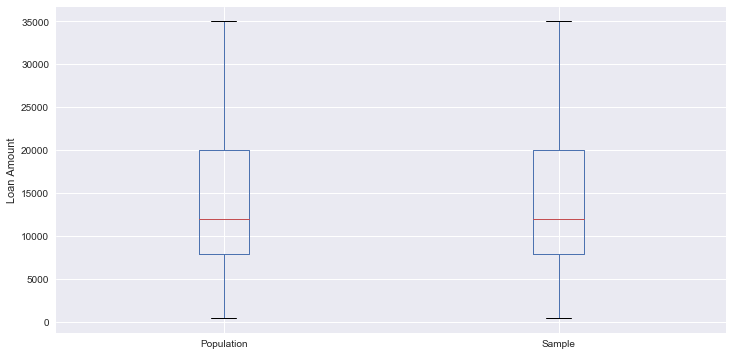

In [82]:
#boxplot of sample and population statistics
pop_to_sample_df.boxplot()
plt.ylabel("Loan Amount");

We can see that the sample statistics are very close to the population statistics.  In fact, the median and mode are exactly the same and the means vary just slightly.

#### 2)	Comparing Variance from C3 Grade Interest Rates and A1 Grade Interest Rates

In [83]:
print "C3 Interest Rate Variance: " + '{:.3f}'.format(loan_sample_df.int_rate[loan_sample_df.sub_grade == 'C3'].var())

C3 Interest Rate Variance: 0.723


In [84]:
print "A1 Interest Rate Variance: " + '{:.3f}'.format(loan_sample_df.int_rate[loan_sample_df.sub_grade == 'A1'].var())

A1 Interest Rate Variance: 0.026


We can easily see that the variance of interest rates for loans with a C3 Subgrade is much larger that that of A1 loans.  We should assume that there are several other factors affecting the interest rates of those loans with a C3 grade while those loans with an A1 grade most likely have their interest rates locked down and less affected by other borrower variables.

#### 3) Confidence Interval of Interest Rate on C3 Loans

In [85]:
loan_sample_df.int_rate[loan_sample_df.sub_grade == 'C3'].describe()

count    2434.000000
mean       14.681635
std         0.850300
min         6.000000
25%        13.980000
50%        14.640000
75%        15.610000
max        15.800000
Name: int_rate, dtype: float64

In [86]:
#store z-score of a 99% confidence interval in a 2-tailed test
z_score = 2.575

#calculate sample standard deviation (population std dev/sqrt(sample size))
sample_std_dev = loans_df['int_rate'].std()/sqrt(len(loan_sample_df[loan_sample_df.sub_grade == 'C3']))


sample_rate_mean = loan_sample_df.int_rate[loan_sample_df.sub_grade == 'C3'].mean()
sample_rate_low_ci = loan_sample_df.int_rate[loan_sample_df.sub_grade == 'C3'].mean() \
                    - (z_score*sample_std_dev)
sample_rate_high_ci = loan_sample_df.int_rate[loan_sample_df.sub_grade == 'C3'].mean() \
                    + (z_score*sample_std_dev)

print "Confidence Interval: " + str('{:.2f}'.format(sample_rate_low_ci)) + ", " + str('{:.2f}'.format(sample_rate_mean)) \
            + ', ' + str('{:.2f}'.format(sample_rate_high_ci))
    
print "Sample Std Dev: " + '{:.3f}'.format(sample_std_dev)

Confidence Interval: 14.45, 14.68, 14.91
Sample Std Dev: 0.088


Looking at a 99% confidence, we determined the z-score should be 2.575 based on a public z-table found.  Knowing the population standard deviation (4.35), we are able to calculate a sample standard deviation by dividing the population standard deviation by the square root of the sample size.  With a sample standard deviation of .088, this equals a confidence interval .227 less than and greater than the sample mean.  

This means that if we were to pull an infinte amount of samples with a C3 subgrade score, we are 99% sure that the mean of any those samples would fall between 14.45 and 14.91.

If this sample size were to increase, then our confidence interval would start to become smaller as our sample standard deviation would be come smaller and we would be more confident that the population mean would be closer to our sample mean.

#### 4) What kind of distribution best fits Lending Club's loans?

In [87]:
dist_loan_df = loans_df.ix[:, ['int_rate', 'annual_inc', 'loan_amnt']]

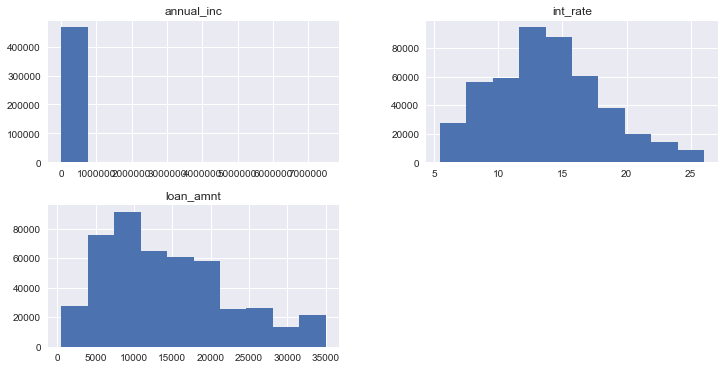

In [88]:
dist_loan_df.hist();

Looking at these three quantitative variables, our data seems to trend towards being negatively skewed.

## Hypothesis Testing: Is There a Difference Between Groups?

Based on our previous analysis of bad loans vs. good loans, we are going to perform some statistical analysis to determine whether some categories of loans have a statistically significantly different default rate.

One change we'll make based on the additional research that we've done on the status of the loans is to only count those loans that have Defaulted or been Charged Off.  Before we counted those loans that have been late for 31-120 days, but have since learned that also they are trending towards being a bad loan, they should not be considered a bad loan at this point.

In [89]:
def set_flag(x):
    bad_status = ['Charged Off','Does not meet the credit policy.  Status:Charged Off','Default']
    if x in bad_status:
        return 1
    else:
        return 0
    
loans_df['loan_status_flag'] = loans_df.loan_status.map(set_flag)

#### Population Default Rate Statistics

In [90]:
print "Population Default Rate Proportion: " + str('{:.4f}'.format(loans_df.loan_status_flag.mean()))

Population Default Rate Proportion: 0.0496



### Statistically significant loan categories for default rates

Based on our analysis from the last assignment, we'd like to see if some of the categories we analyzed produce statistically signficant different default rates.

For all of our tests, we will be performing a two-tailed test with a 95% confidence interval.  We will take a random sample with a sample size based on the set of data that we are looking at.  

Our null hypothesis for default rates will be the population default rate as we know we have the entire population and can base our analysis off of this.  The tests will determine whether the samples pulled can disprove the null hypothesis based on the criteria of the samples pulled.

In [91]:
#z-score based on a 95% confidence interval of a two-tailed test
z_score = 1.96
#null hypothesis proportion is the population mean that we'll be testing against
null_hyp_prop = loans_df.loan_status_flag.mean()

In [92]:
def conf_int(pop_mean, sample):
    std_err = sqrt((pop_mean*(1- null_hyp_prop))/sample)
    
    CI_low = null_hyp_prop - (z_score*std_err)
    CI_high = null_hyp_prop + (z_score*std_err)
    
    return CI_low, CI_high

### Analyzing Borrowers with High Counts of Open Credit Accounts

In our earlier analysis, we saw that there were outliers of people with MUCH higher counts of open credit accounts than the standard borrower.  There were some borrowers with over 70 open credit lines.

With such big outliers, we will take a sample of 500 borrowers from the top five percent of open accounts (those with greater than 20) to determine if their default rates are statistically significant from the population mean.

We will not just test to see if the rate is signicantly higher, but we will check both sides of the population mean to see if it could possibly be significantly lower as well.  Therefore, we will be performing a two-tailed test with a 95% confidence interval.

In [93]:
#DataFrame with sampling of loans with more than 20 open credit accounts saved and re-loaded

sample_size = 500

#high_open_acct_df = loans_df[loans_df.open_acc > 20].sample(sample_size)
#high_open_acct_df.to_pickle('high_open_acct_df.pkl')

high_open_acct_df = pd.read_pickle('high_open_acct_df.pkl')

In [94]:
ci_low, ci_high = conf_int(null_hyp_prop, sample_size)
print "Confidence Interval: " + '{:.4f}'.format(ci_low) + ", " + '{:.4f}'.format(ci_high)

Confidence Interval: 0.0306, 0.0687


In [95]:
print "Sample Default Rate Proportion (p-value): " + '{:.4f}'.format(high_open_acct_df.loan_status_flag.mean())

Sample Default Rate Proportion (p-value): 0.0340


With a p-value of .034, our test does not fall into the critical region of the distribution.  Therefore, we cannot reject the null hypothesis.

##### Business Analysis of Borrowers with a High Amount of Open Credit Accounts

Open credit lines give us a picture of how many different institutions a borrower is being issued credit from.  With so many different mouths to feed, there could be a concern that a borrower would need to pick and choose which lenders to repay if they were to be short on money.  On the other hand, with so many open credit accounts other lenders are trusting these borrowers to repay their loans. So, they could just be very good at working with revolving debts.

When looking at the borrowers with more than 20 open credit accounts (the top 5% of that category), we wanted to see if those borrowers had any positive or negative traits associated with defaulting on their loans.  Based on our analysis, we can  say that those people with a high amount of open credit accounts do not default on their loans any more or any less than the average borrower.

### Analyzing Borrowers with High Debt to Income Ratios

In our earlier analysis, we displayed a histogram on the borrowers and their associated debt to income ratio (DTI).  There was a very small bucket of people with a DTI of 35-40 in the upper range.  We wanted to take a look at whether people with a higher DTI will typically have a higher percentage of defaulted loans.

In order to quantify the ratio we want to look at, we will look at the top 5% of the DTI distribution.  This means we will be taking a sample of the population that has a DTI of over 30.

In [96]:
#DataFrame with sampling of loans with a DTI of higher than 30 saved and re-loaded

sample_size = 500

#high30_dti_df = loans_df[loans_df.dti > 30].sample(sample_size)
#high30_dti_df.to_pickle('high30_dti_df.pkl')

high30_dti_df = pd.read_pickle('high30_dti_df.pkl')

In [97]:
ci_low, ci_high = conf_int(null_hyp_prop, sample_size)
print "Confidence Interval: " + str('{:.4f}'.format(ci_low)) + ", " + str('{:.4f}'.format(ci_high))

Confidence Interval: 0.0306, 0.0687


In [98]:
print "Sample Default Rate Proportion (p-value): " + str('{:.4f}'.format(high30_dti_df.loan_status_flag.mean()))

Sample Default Rate Proportion (p-value): 0.0600


With a p-value of .0600, our test does not fall into the critical region of the distribution.  Therefore, we cannot reject the null hypothesis.

What if we were just to look at that small bucket of borrowers that had a DTI higher than 35 that we saw in the histogram?

##### Gather a random sample of the population

In [99]:
#DataFrame with sampling of loans with a DTI of higher than 35 saved and re-loaded

sample_size = 300

#high35_dti_df = loans_df[loans_df.dti > 35].sample(sample_size)
#high35_dti_df.to_pickle('high35_dti_df.pkl')

high35_dti_df = pd.read_pickle('high35_dti_df.pkl')

##### Calculate the Confidence Interval

In [100]:
ci_low, ci_high = conf_int(null_hyp_prop, sample_size)
print "Confidence Interval: " + str('{:.4f}'.format(ci_low)) + ", " + str('{:.4f}'.format(ci_high))

Confidence Interval: 0.0251, 0.0742


##### Calculate the p-value

In [101]:
print "Sample Default Rate Proportion (p-value): " + str('{:.4f}'.format(high35_dti_df.loan_status_flag.mean()))

Sample Default Rate Proportion (p-value): 0.0000


With a p-value of 0.0, statisically this would tell us that this falls in the critical range and that loans with a DTI of over 35 introduce less risk than the normal loan.

However, after additional analysis, this seems like an anomoly.  If I dig further into the data, it looks like loans with a DTI of 35 or greater only started on August 1, 2014 and this data was pulled in February 2015.  Enough time hasn't even passed since the first loan with a borrower DTI over 35 to go into a Bad Loan status.  This is what explains the small bucket more than Lending Club's resistance to issue loans to borrowers in this DTI range.

In [102]:
print "First issue date of a loan to a borrower of 35 DTI or higher: \n" + min(high35_dti_df['issue_d_fmt'])

First issue date of a loan to a borrower of 35 DTI or higher: 
08-01-2014


##### Business Analysis of Borrowers with a High DTI Ratio

Debt-to-Income gives us a good picture of how much disposable income a borrower would have remaining to pay off any additional loans.  We'll see some correlation between open accounts and DTI, but this number should give a better idea of how much actual funds a borrower has remaining to pay a loan.

At first, we analyzed those loans in the top 5% of DTI to see if those introduced any inherent risks to our lenders.  Turns out that these loans tend to have the same risk involved with the entire population of loans, so we should continue approving loans to borrows with a DTI of 30 or over.

One thing that looked intriguing was that those individuals who had a DTI over 35 were a very small bucket and could be a high risk.  After the first test, it looked as though these individuals posed LESS risk.  But upon further analysis, it seems as though this DTI level is a new allowance for Lending Club and these loans haven't even had enough time to default.  I would check with a Subject Matter Expert to double-check this assumption, but I would still recommend coming back in a year or so to check and see if this new allowance is introducing a risk to the lenders.

### Analyzing Borrowers with a Loan Purpose for Small Businesses

Earlier, we were able to plot the loan purposes and how the percentages were split between each of those puproses.  The highest default rate was statistically tied to loans given out for the purposes of starting (or adding funding to) a small business.

If it turns out that lending to people for the purpose of a small business increases our risk of losing all the money given out for that loan, then we will want to consider some actions to help mitigate that risk.

##### Create a Sample

In [103]:
#DataFrame with sampling of loans with more a loan purpose of Small Business saved and re-loaded

sample_size = 500

#small_bus_df = loans_df[loans_df.purpose == 'small_business'].sample(sample_size)
#small_bus_df.to_pickle('small_bus_df.pkl')

small_bus_df = pd.read_pickle('small_bus_df.pkl')

##### Define Confidence Interval

In [104]:
ci_low, ci_high = conf_int(null_hyp_prop, sample_size)
print "Confidence Interval: " + str('{:.4f}'.format(ci_low)) + ", " + str('{:.4f}'.format(ci_high))

Confidence Interval: 0.0306, 0.0687


##### Calculate p-value

In [105]:
print "Sample Default Rate Proportion (p-value): " + str('{:.4f}'.format(small_bus_df.loan_status_flag.mean()))

Sample Default Rate Proportion (p-value): 0.1860


With a p-value of .186, our test does  fall into the critical region of the distribution.  Therefore, we can reject the null hypothesis that the default rate for loans for Small Businesses equal our population's default rate.

##### Business Analysis of Loans for the Purpose of a Small Business

Starting a business is always a risky venture.  It is a common knowledge that most new businesses do not succeed and it looks to hold true with loans that are issued to borrowers for small business investments.

For the sample that pulled from the Lending Club loan population, 18.6% of loans have defaulted which is over 3 times larger than the typical default rate.

We can assume that Lending Club does not want to discourage people from investing in small businesses, but it is in Lending Club's interest to mitigate the risk of lending for this purpose.  

Several actions can be taken at this point:
1.  Look at the industry standard interest rates for issuing loans to borrowers for a small business.  Align ourselves with the industry to continue to incentivize our lenders by raising the interest rate while still staying competitive.
2.  Continue analysis specifically on loans for Small Businesses.  Capture addtional information that allows us to further vet the details of the business that is being borrowed for.  Based on any additional information gathered, we can best determine whether the loan should be accepted or not.
3.  Completely stop issuing loans for small businesses.  If small business loans are only a small portion of the business, then we can promote a higher loan success rate and only lose a small portion of our business.  This most likely won't stop people from filling out a false purpose and this does not align ourselves with the lending industry.  However, it is still an option.

** 1.  Investigate the interest rate for small businesses **

First, let's see what the difference in Lending Club's interest rates is between the overall population, the population of loans for small businesses, and those loans which are now defaulted which were for small businesses.

In [106]:
print "Lending Club Average Interest Rate: " + str('{:.4f}'.format(loans_df.int_rate.mean()))

print "Lending Club Small Business Average Interest Rate: " +  \
            str('{:.4f}'.format(loans_df[loans_df.purpose == 'small_business'].int_rate.mean()))
    
print "Lending Club Bad Loan Small Business Average Interest Rate: " +  \
            str('{:.4f}'.format(loans_df.int_rate[(loans_df['purpose'] == 'small_business') \
                                                  & (loans_df['loan_status_flag'] == 1)].mean()))
small_bus_int_rate_inc = loans_df[loans_df.purpose == 'small_business'].int_rate.mean() - loans_df.int_rate.mean()

Lending Club Average Interest Rate: 13.8302
Lending Club Small Business Average Interest Rate: 15.9840
Lending Club Bad Loan Small Business Average Interest Rate: 15.8092


It looks like there is about a 2% higher interest rate on loans for small businesses.  Can we quantify how much money our lenders are losing to see if this interest rate is mitigating their risk or not?

We're definiing lost money as that amount of the loan funded by Lending Club minus the amount that we collected.  Obviously, this doesn't take into account the expected interest from the loan, but we'll just analyze from getting the pure principal back.

In [107]:
###Create DataFrame of Bad Small Business Loans
bad_small_bus_loans_df = loans_df.loc[(loans_df['purpose'] == 'small_business') & (loans_df['loan_status_flag'] == 1)]

###Calculate average amount funded on bad business loans
print "Avg Amount Funded Per Loan: $" +  str('{:0,.2f}'.format((bad_small_bus_loans_df['funded_amnt'].sum()) \
                                       /len(bad_small_bus_loans_df)))
###Calculate average amount funded minus average amount paid (amount lost) on bad business loans
print "Avg Amount Lost Per Loan: $" + \
        str('{:0,.2f}'.format((bad_small_bus_loans_df['funded_amnt'].sum() - \
            bad_small_bus_loans_df['total_pymnt'].sum())/len(bad_small_bus_loans_df)))
###Calculate total amount funded minus total amount paid (not lost) on bad business loans  
print "Net Amount Lost on Bad Small Business Loans: $" + str('{:0,.2f}'.format(bad_small_bus_loans_df['funded_amnt'].sum() - \
            bad_small_bus_loans_df['total_pymnt'].sum()))

Avg Amount Funded Per Loan: $15,572.36
Avg Amount Lost Per Loan: $8,940.22
Net Amount Lost on Bad Small Business Loans: $9,405,113.22


While 2% can help our lenders be more comfortable with taking on the increased risk of a small business loan, it doesn't look look like it's nearly enough to make up for the average amount of money lost.

**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Additional Analysis: What percentage of money lost on bad loans is from small business loans?  Is this our biggest problem? **

In [108]:
print "Net Amount Lost Overall on Bad Loans: $" + \
        str('{:0,.2f}'.format(loans_df.funded_amnt[loans_df['loan_status_flag']==1].astype('float').sum() - \
            loans_df.total_pymnt[loans_df['loan_status_flag']==1].astype('float').sum()))

print "Percentage of Lost Investment On Bad Loans From Small Business Loans: " + \
        str('{:0,.2f}'.format((bad_small_bus_loans_df['funded_amnt'].sum() - \
            bad_small_bus_loans_df['total_pymnt'].sum())/(loans_df.funded_amnt[loans_df['loan_status_flag']==1].sum() - \
            loans_df.total_pymnt[loans_df['loan_status_flag']==1].sum())*100)) + "%"

Net Amount Lost Overall on Bad Loans: $192,267,457.38
Percentage of Lost Investment On Bad Loans From Small Business Loans: 4.89%


It looks like Small Business loans is less than 5% of money lost for our investors!  While this is a problem, we clearly should try and find a larger categorization of bad loans to resolve.  We should analyze this at a later date.

** 2.  Investigate other factors that can mitigate risk of small business loan **

In [109]:
#function to return a dataframe with grade and "net amount" only
grade_net_df = get_net_amount(bad_small_bus_loans_df,'grade', 'funded_amnt','total_pymnt')

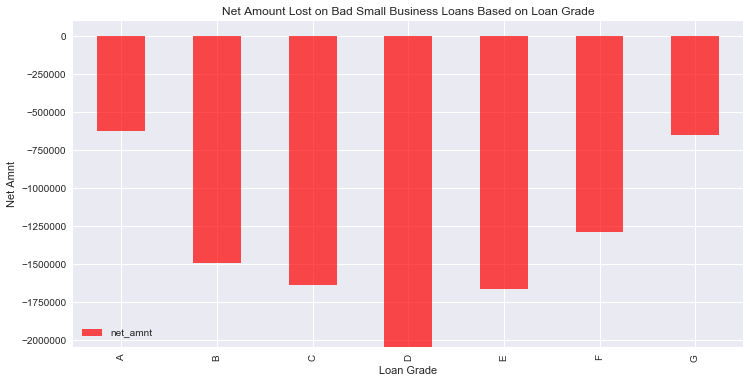

In [110]:
ax1 = grade_net_df.plot(kind='bar', label = "Bad Loans", alpha =.7,color='r')
ax1.set_xlabel("Loan Grade")
ax1.set_ylabel("Net Amnt")
ax1.set_title("Net Amount Lost on Bad Small Business Loans Based on Loan Grade")

plt.show()

In [111]:
#use describe to find quartiles of DTI
bad_small_bus_loans_df.dti.describe()

count    1052.000000
mean       13.359373
std         7.292585
min         0.000000
25%         7.647500
50%        13.000000
75%        18.580000
max        34.780000
Name: dti, dtype: float64

In [112]:
#create dataframe with bad small business loans counted into DTI quartiles
bad_small_bus_loans_df['dti_qrt'] = create_quartiles(0, 7.64, 13.0, 18.58, 1000,bad_small_bus_loans_df.dti)

C:\Users\phooper\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [113]:
#create dataframe to return quartiles and the net amount lost
dti_net_df = get_net_amount(bad_small_bus_loans_df,'dti_qrt','funded_amnt','total_pymnt')

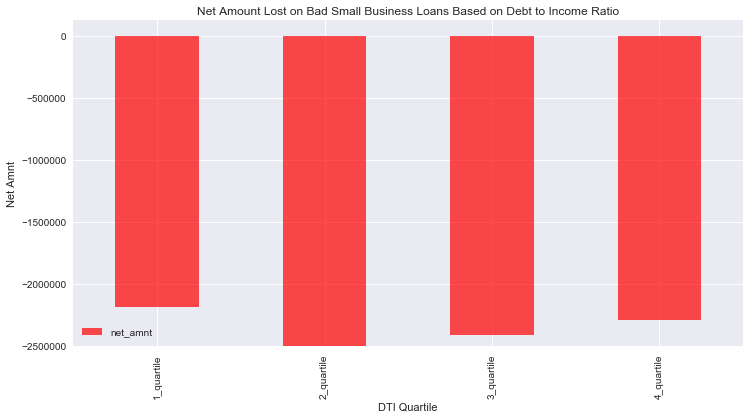

In [114]:
ax1 = dti_net_df.plot(kind='bar', label = "Bad Loans", alpha =.7,color='r')
ax1.set_xlabel("DTI Quartile")
ax1.set_ylabel("Net Amnt")
ax1.set_title("Net Amount Lost on Bad Small Business Loans Based on Debt to Income Ratio")

plt.show()

In [115]:
#find quartiles of bad small business loans and their payment to income ratio
bad_small_bus_loans_df.payment_inc_ratio.describe()

count    1052.000000
mean        8.802511
std         4.641245
min         0.461182
25%         5.318605
50%         8.146750
75%        12.087625
max        29.755800
Name: payment_inc_ratio, dtype: float64

In [116]:
#create dataframe with bad small business loans counted into PTI quartiles
bad_small_bus_loans_df['pir_qrt'] = create_quartiles(0, 5.31, 8.14, 12.08, 1000,bad_small_bus_loans_df.payment_inc_ratio)

C:\Users\phooper\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [117]:
#return dataframe with Payment income ratio quartiles and their net amount
bad_pir_net_df = get_net_amount(bad_small_bus_loans_df,'pir_qrt', 'funded_amnt','total_pymnt')

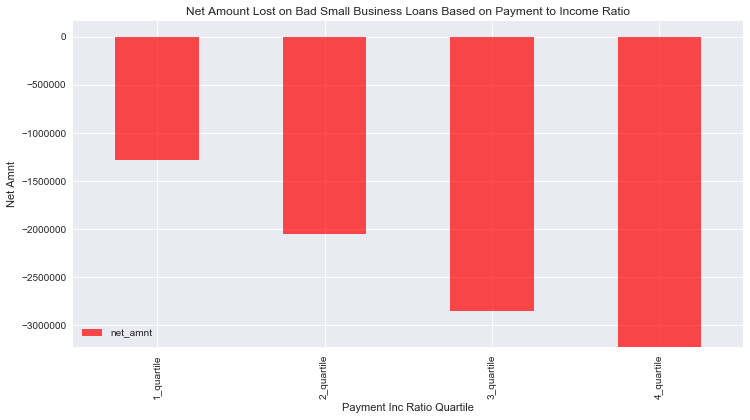

In [118]:
#plot net amount lost based on PTI quartiles
ax1 = bad_pir_net_df.plot(kind='bar', label = "Bad Loans", alpha =.7,color='r')
ax1.set_xlabel("Payment Inc Ratio Quartile")
ax1.set_ylabel("Net Amnt")
ax1.set_title("Net Amount Lost on Bad Small Business Loans Based on Payment to Income Ratio")

plt.show()

We were able to analyze the grade of the loan, the debt to income ratio of the borrowers (broken down into quartiles), and the payment to income ratio of the borrowers (broken down into quartiles).

While there were higher amounts of money lost on loans with a grade of D, the distribution is in line with loans issued in general.  Therefore, we don't see an anomoly based on grade.

When the net amount lost was analyzed by Debt to Income Ratio quartiles, we saw a completely flat distribution which will lead us to believe we can't break bad small business loans up into those sectors.

Payment to Income ratio (when broken up into quartiles) seems to give us a strong trend that those whose monthly income is mostly consumed by debt payments tend to default the most amount of money to our lenders.  If we wanted to limit the loans accepted for small businesses, we could look into not accepting those loans with borrowers with a certain payment to income ratio (8.14 being the median).

** 3.  Investigate Business Impact of Not Allowing Small Business Loans**

In [119]:
print "Total Funded Amount for all loans: $" + \
            str('{:0,.2f}'.format(loans_df.funded_amnt.astype('float').sum()))
    
print "Total Funded Amount for Small Business Loans: $" + \
            str('{:0,.2f}'.format(loans_df.funded_amnt[(loans_df.purpose == 'small_business')].\
                                  astype('float').sum()))

print "Percentage of Loans that are Small Business Loans: " + \
         str('{:0,.2f}'.format(((loans_df.funded_amnt[(loans_df.purpose == 'small_business')].\
                                  astype('float').sum())/loans_df.funded_amnt.astype('float').sum()*100))) + "%"

Total Funded Amount for all loans: $6,664,082,450.00
Total Funded Amount for Small Business Loans: $106,330,000.00
Percentage of Loans that are Small Business Loans: 1.60%


It looks as though Small Business loans make up 1.6% of the total funding provided by lending club, but contribute to 4.89% of the net amount lost on bad loans.  

** Small Business Loan Conclusion **

Based on numbers alone, we do have justification to not allow small business loans.  But this could lead to losing consumers in other markets of our business as well as false reports on the application of our loans.

I would recommend continuing the investigation of our industry to see if we can increase the loan interest rate of those applying for small business loans.  This in combination with restricting small business loans to those only with a Payment to Income ratio under 8.14 would help mitigate risk while still allowing consumers to successfully try their hand at beginning their new dream.

### Analyzing Borrowers who do not Own or Rent a Residence

Earlier, we were able to plot the home ownership status of our borrowers and how that status related to percentage of loans currently in a bad status.  The highest default rate was statistically tied to borrowers who did not categorize their home ownership under Mortgage, Rent, or Own.  What other categories could there be?

Let's see if you're not able to define your home ownership status under those three categories, if you are more likely to default on your loan.

##### Create a Sample

In [120]:
#make sure our sample size is within our population
len(loans_df[loans_df.home_ownership == 'OTHER'])

233

In [121]:
#DataFrame with sampling of loans with more a loan purpose of Small Business saved and re-loaded

sample_size = 50

#other_own_df = loans_df[loans_df.home_ownership == 'OTHER'].sample(sample_size)
#other_own_df.to_pickle('other_own_df.pkl')

other_own_df = pd.read_pickle('other_own_df.pkl')

##### Define Confidence Interval

In [122]:
ci_low, ci_high = conf_int(null_hyp_prop, sample_size)
print "Confidence Interval: " + str('{:.4f}'.format(ci_low)) + ", " + str('{:.4f}'.format(ci_high))

Confidence Interval: -0.0106, 0.1099


##### Calculate p-value

In [123]:
print "Sample Default Rate Proportion (p-value): " + str('{:.4f}'.format(other_own_df.loan_status_flag.mean()))

Sample Default Rate Proportion (p-value): 0.2000


With a p-value of .200, our test does fall into the critical region of the distribution.  Therefore, we can reject the null hypothesis that the default rate for loans where the borrower lists Other for Home Ownership status is equal to our population's default rate.

##### Business Analysis of Loans where Borrower does not state specific Home Ownership status

Most adults applying for a loan either own (either fully or though a mortgage) or rent their place of residence.  Other than that, individuals would most likely be staying for free with friends or family, staying in a hotel long-term, or just not have a place of residence at all.

For the sample of people who did not list Own, Rent, or Mortgage for theier home ownership status pulled from the Lending Club loan population, 20% of loans have defaulted which is over 4 times larger than the typical default rate at Lending Club

It would be pretty easy to assume that those who do not have a residence of their own present a much higher risk to Lending Club lenders.  We can either:
1.  Stop lending to borrowers who are not able to verify that they rent or own a home.
2.  Analyze other characteristics of a borrower to ensure that they can present a safer risk in repaying the loan.

** 1.  Investigate Business Impact of Not Allowing Loans for Borrowers who do not Own or Rent Residence**

In [124]:
print "Total Funded Amount for all loans: $" + \
            str('{:0,.2f}'.format(loans_df.funded_amnt.astype('float').sum()))
    
print "Total Funded Amount for Other Home Ownership: $" + \
            str('{:0,.2f}'.format(loans_df.funded_amnt[(loans_df.home_ownership == 'OTHER')].\
                                  astype('float').sum()))

print "Percentage of Loans that are Other Home Ownership (in funded $): " + \
         str('{:0,.2f}'.format(((loans_df.funded_amnt[(loans_df.home_ownership == 'OTHER')].\
                                  astype('float').sum())/loans_df.funded_amnt.astype('float').sum()*100))) + "%"

print "Percentage of Bad Loans that are Other Home Ownership (in net amount lost $): " + \
    str('{:0,.2f}'.format((loans_df.funded_amnt[(loans_df['loan_status_flag']==1) & \
                                                (loans_df['home_ownership']=='OTHER')].astype('float').sum() - \
      loans_df.total_pymnt[(loans_df['loan_status_flag']==1) & (loans_df['home_ownership']=='OTHER')].astype('float').sum()) / \
    (loans_df.funded_amnt[(loans_df['loan_status_flag']==1)].astype('float').sum() - \
      loans_df.total_pymnt[(loans_df['loan_status_flag']==1)].astype('float').sum()) * 100)) + "%"

Total Funded Amount for all loans: $6,664,082,450.00
Total Funded Amount for Other Home Ownership: $2,585,825.00
Percentage of Loans that are Other Home Ownership (in funded $): 0.04%
Percentage of Bad Loans that are Other Home Ownership (in net amount lost $): 0.11%


It looks as though loans where borrowers do not state a specific home ownership make up .04% of the total funding provided by lending club, but contribute to .11% of the net amount lost on bad loans.  This is an extremely small amount on both factors.

Without even going further into analyze good parts of this dataset, I would say with confidence that if there are no regulations forcing us to accept these loans, then we should only allow those borrowers who are able to provide proof of home ownership or renting ability to be accepted for a loan.

## Correlation in Loan Data

List 5 sets of data points that have correlation.  Calculate the correlation where possible.

**1. Loan Grade and Default Rate **

We saw from our earlier analysis that there looks to be a strong trend between the grade assigned to a loan and the default rate of those loans.  We can see a definite trend in the chance of a loan defaulting based on the grade assigned to the loan.

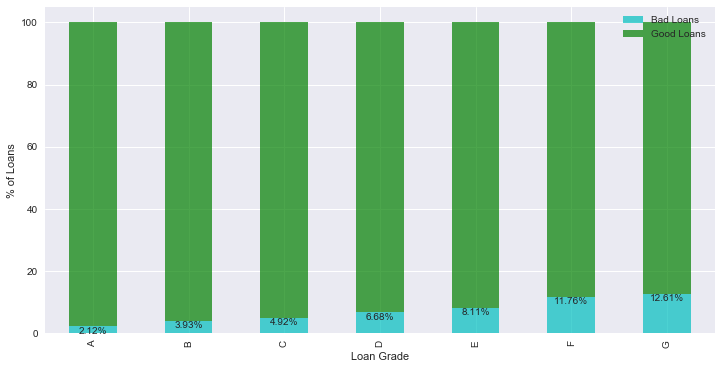

In [125]:
bad_loan_grade_freq = Counter(loans_df.grade[loans_df.loan_status_flag == 1])
good_loan_grade_freq = Counter(loans_df.grade[loans_df.loan_status_flag == 0])

#return sorted order of grades and counts
bad_grades, bad_grade_counts = sort_for_graph(bad_loan_grade_freq,"key","asc")
good_grades, good_grade_counts = sort_for_graph(good_loan_grade_freq,"key","asc")

bad_grade_pct = pd.Series.from_array([bad_grade_counts[i]/(bad_grade_counts[i]+good_grade_counts[i]) \
                 * 100 for i in range(len(bad_grade_counts))])
good_grade_pct = pd.Series.from_array([good_grade_counts[i]/(bad_grade_counts[i]+good_grade_counts[i]) \
                  * 100 for i in range(len(good_grade_counts))])

ax1 = bad_grade_pct.plot(kind='bar', label = "Bad Loans", alpha = .7, color='c')
ax1.set_xticklabels(bad_grades)
ax2 = good_grade_pct.plot(kind='bar', label = "Good Loans", alpha = .7, bottom=bad_grade_pct, color='g')
ax2.set_xlabel("Loan Grade")
ax2.set_ylabel("% of Loans")
ax2.set_xticklabels(bad_grades)

rects = ax1.patches
labels = ["{0:.2f}%".format(bad_grade_pct[i]) for i in xrange(len(bad_grade_pct))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height - 3, label, ha='center', va='bottom')
               
plt.legend(loc='upper right')
plt.show()

**2. Not Renting or Owning Home and Default Rate **

Those with "Other" listed as their Home Ownership status strongly correlated to a higher default rate than the average loan.  When combining that feature and the Payment to Income ratio, there is an even stronger chance that the borrower will not be able to pay the loan back.

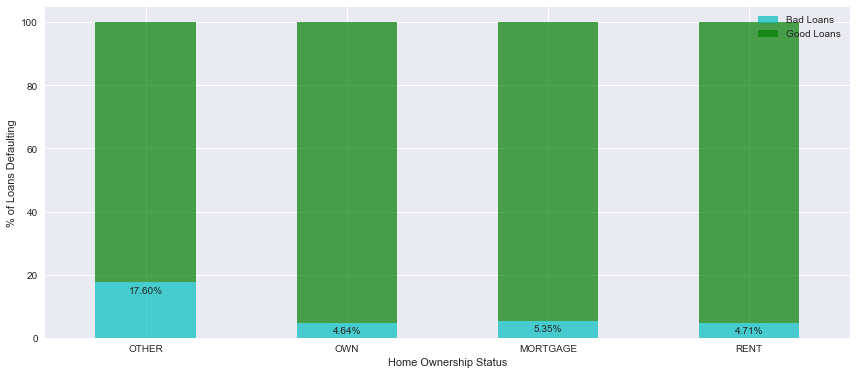

In [126]:
bad_loan_ho_freq = Counter(loans_df.home_ownership[loans_df.loan_status_flag == 1])
good_loan_ho_freq = Counter(loans_df.home_ownership[loans_df.loan_status_flag == 0])

#return sorted order of hos and counts
bad_ho, bad_ho_counts = sort_for_graph(bad_loan_ho_freq,"value","asc")
good_ho, good_ho_counts = sort_for_graph(good_loan_ho_freq,"value","asc")

bad_ho_pct = pd.Series.from_array([bad_ho_counts[i]/(bad_ho_counts[i]+good_ho_counts[i]) \
                   * 100 for i in range(len(bad_ho_counts))])
good_ho_pct = pd.Series.from_array([good_ho_counts[i]/(bad_ho_counts[i]+good_ho_counts[i]) \
                    * 100 for i in range(len(good_ho_counts))])
    
ax1 = bad_ho_pct.plot(kind='bar', label = "Bad Loans", alpha = .7, color='c')
ax2 = good_ho_pct.plot(kind='bar', label = "Good Loans", alpha = .7, bottom=bad_ho_pct, color='g')
ax2.set_xlabel("Home Ownership Status")
ax2.set_ylabel("% of Loans Defaulting")
ax2.set_xticklabels(bad_ho)

rects = ax1.patches
labels = ["{0:.2f}%".format(bad_ho_pct[i]) for i in xrange(len(bad_ho_pct))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height - 4, label, ha='center', va='bottom')

plt.legend(loc='upper right')
plt.tight_layout()
plt.xticks(rotation="horizontal")
plt.show()

** 3.  Payment to Income Ratio and the Amount Owed on Bad Loans **

In [127]:
bad_loans_df = loans_df[loans_df.loan_status_flag == 1]

In [128]:
#create dataframe with bad small business loans counted into PTI quartiles
bad_loans_df['pir_qrt'] = create_quartiles(0, 5.31, 8.14, 12.08, 1000,bad_loans_df.payment_inc_ratio)

C:\Users\phooper\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [129]:
#return dataframe with Payment income ratio quartiles and their net amount
bad_loan_pir_net_df = get_net_amount(bad_loans_df,'pir_qrt', 'funded_amnt','total_pymnt')

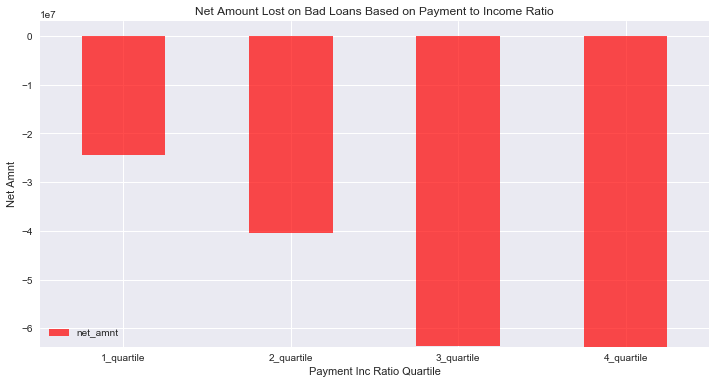

In [130]:
#plot net amount lost based on PTI quartiles
ax1 = bad_loan_pir_net_df.plot(kind='bar', label = "Bad Loans", alpha =.7,color='r')
ax1.set_xlabel("Payment Inc Ratio Quartile")
ax1.set_ylabel("Net Amnt")
ax1.set_title("Net Amount Lost on Bad Loans Based on Payment to Income Ratio")
plt.xticks(rotation="horizontal")
plt.show()

** 4.  Inquiries in the Last 6 Months and Default Rate **

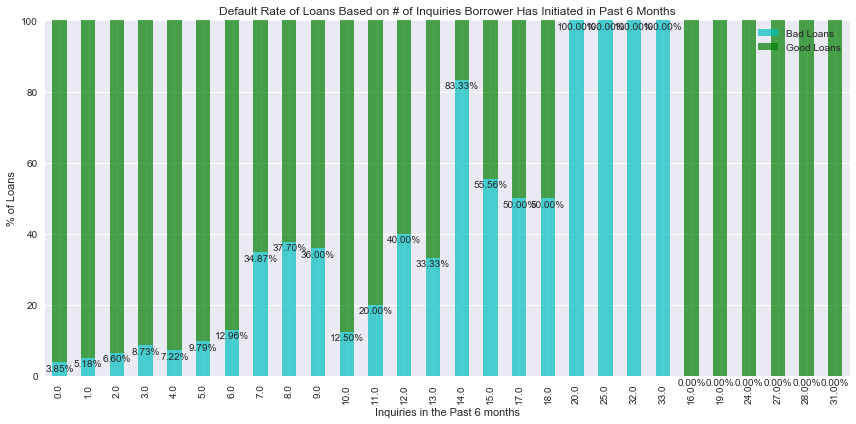

In [131]:
#Count number of bad loans for each number of inquiries in past 6 months
bad_inqs_df = pd.DataFrame.from_dict(Counter(loans_df.inq_last_6mths[loans_df.loan_status_flag == 1]), \
                                        orient='index').reset_index()
#Count number of good loans for each number of inquiries in past 6 months
good_inqs_df = pd.DataFrame.from_dict(Counter(loans_df.inq_last_6mths[loans_df.loan_status_flag == 0]), \
                                         orient='index').reset_index()
#Merge two dataframes
inqs_df = bad_inqs_df.merge(good_inqs_df, left_on='index', right_on='index', how='outer')
#Where there is no join, place a zero
inqs_df.fillna(0, inplace=True)
#rename columns to something useful
inqs_df = inqs_df.rename(columns={'index':'delinqs', '0_x':'bad_count', '0_y':'good_count'})

#create new columns for pct calcs
inqs_df['bad_delinq_pct'] = (inqs_df['bad_count']/(inqs_df['bad_count']+inqs_df['good_count'])*100)
inqs_df['good_delinq_pct'] = (inqs_df['good_count']/(inqs_df['bad_count']+inqs_df['good_count'])*100)

#plot default rates for each inquiry number
ax1 = inqs_df.bad_delinq_pct.plot(kind='bar', label = "Bad Loans", alpha = .7, color='c')
ax2 = inqs_df.good_delinq_pct.plot(kind='bar', label = "Good Loans", alpha = .7, bottom=inqs_df.bad_delinq_pct, color='g')
ax2.set_title("Default Rate of Loans Based on # of Inquiries Borrower Has Initiated in Past 6 Months")
ax2.set_xlabel("Inquiries in the Past 6 months")
ax2.set_ylabel("% of Loans")
ax2.set_xticklabels(inqs_df.delinqs)

rects = ax1.patches
labels = ["{0:.2f}%".format(inqs_df.loc[i,'bad_delinq_pct']) for i in xrange(len(inqs_df))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height - 3, label, ha='center', va='bottom')
               
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Here we can see an upward trend of borrowers who have higher numbers of inquiries against their credit history in the past 6 months and the chance that they default on a loan.  This is a high correlation that can be used to predict a bad loan in the future.

** 5.  Default Rate Based on Months Since Last Credit Inquiry **

In [132]:
def months_since_pull(x):
    if x == "00-00-0000":
        return 0
    else:
        td = date.fromtimestamp(mktime(strptime('03-01-2015',"%m-%d-%Y")))
        return (td - date.fromtimestamp(mktime(strptime(x,"%m-%d-%Y")))).days//(365/12)
   

loans_df['months_since_crd_pull'] = loans_df.loc[:,'last_credit_pull_d_fmt'].map(months_since_pull)

In [133]:
#Count number of bad loans for each number of months since credit inquiry
bad_cred_pull_df = pd.DataFrame.from_dict(Counter(loans_df.months_since_crd_pull[loans_df.loan_status_flag == 1]), \
                                        orient='index').reset_index()
#Count number of good loans for each number of months since credit inquiry
good_cred_pull_df = pd.DataFrame.from_dict(Counter(loans_df.months_since_crd_pull[loans_df.loan_status_flag == 0]), \
                                         orient='index').reset_index()
#Merge two dataframes
cred_pull_df = bad_cred_pull_df.merge(good_cred_pull_df, left_on='index', right_on='index', how='outer')
#Where there is no join, place a zero
cred_pull_df.fillna(0, inplace=True)
#rename columns to something useful
cred_pull_df = cred_pull_df.rename(columns={'index':'delinqs', '0_x':'bad_count', '0_y':'good_count'})

#group months into bins up to 70 and then all months above 70
bins = (-1,9,19,29,39,49,59,69,100)
group_names = [str(x*10) +"-"+ str(((x*10)+9)) for x in range(7)]
group_names.append('80+')
cred_pull_df['group_num'] = pd.cut(cred_pull_df.delinqs, bins, labels=group_names)

#sum up months based on grouping
cred_pull_grouped_df = cred_pull_df.groupby(['group_num'], as_index=False).sum()

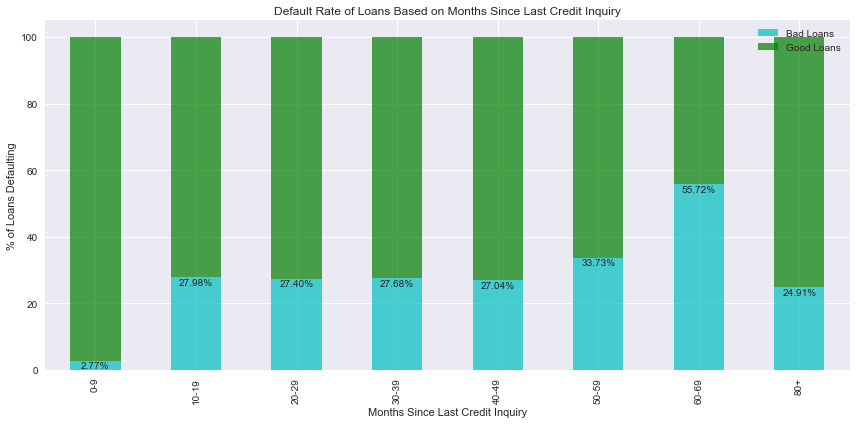

In [134]:
#create new columns for pct calcs
cred_pull_grouped_df['bad_delinq_pct'] = \
(cred_pull_grouped_df['bad_count']/(cred_pull_grouped_df['bad_count']+cred_pull_grouped_df['good_count'])*100)
cred_pull_grouped_df['good_delinq_pct'] = \
(cred_pull_grouped_df['good_count']/(cred_pull_grouped_df['bad_count']+cred_pull_grouped_df['good_count'])*100)

#plot default rates for each month range
ax1 = cred_pull_grouped_df.bad_delinq_pct.plot(kind='bar', label = "Bad Loans", alpha = .7, color='c')
ax2 = cred_pull_grouped_df.good_delinq_pct.plot(kind='bar', label = "Good Loans", alpha = .7,\
                                        bottom=cred_pull_grouped_df.bad_delinq_pct, color='g')
ax2.set_title("Default Rate of Loans Based on Months Since Last Credit Inquiry")
ax2.set_xlabel("Months Since Last Credit Inquiry")
ax2.set_ylabel("% of Loans Defaulting")
ax2.set_xticklabels(cred_pull_grouped_df.group_num)

rects = ax1.patches
labels = ["{0:.2f}%".format(cred_pull_grouped_df.loc[i,'bad_delinq_pct']) for i in xrange(len(cred_pull_grouped_df))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height - 3, label, ha='center', va='bottom')
               
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

We can see that any amount of months over 9 since a credit inquiry has been pulled leads to a considerably higher chance of defaulting on a loan.  0-9 comprises most of the population of borrowers, but those outside of that range pose a risk to our lenders and could be used to predict whether a loan will default or not.